In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]

In [2]:
import fastai as fai
from fastai.basic_data import DataLoader
from data_loader import *
import numpy as np
from torch.utils.data import SubsetRandomSampler
from model import *
from model_bn import *
from torch import optim
import dill
import papermill as pm
from main import *
import pandas as pd

In [3]:
optimizer = 'Adam'
num_workers=8
maxsize=100000
batch_size=2048
n_epochs=500
batch_norm = True
dataset='data/speedup_dataset.h5'

In [4]:
train_dl, val_dl = train_dev_split(dataset, batch_size, num_workers, maxsize)

db = fai.basic_data.DataBunch(train_dl, val_dl)

In [5]:
def criterion(inputs, targets):
    eps = 1e-5
    return torch.mean(torch.abs(targets - inputs)/(targets+eps)*100)

In [6]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size)
else:
    model = Model(input_size, output_size)
    
#criterion = nn.MSELoss()

l = fai.Learner(db, model, loss_func=criterion)

if optimizer == 'SGD':
    l.opt_func = optim.SGD


In [11]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


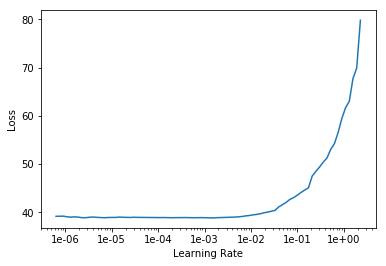

In [12]:
l.recorder.plot()

In [13]:
lr = 0.001

In [14]:
l.fit_one_cycle(300, lr)

epoch,train_loss,valid_loss
1,69.968178,85.605179
2,66.441895,56.247520
3,63.386555,53.371758
4,61.322170,53.186852
5,59.668354,54.909576
6,58.343056,51.773800
7,57.436409,53.187424
8,56.559261,52.113018
9,55.698997,51.065475
10,54.896133,50.632309


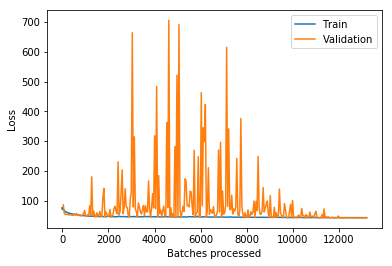

In [17]:
l.recorder.plot_losses()

In [16]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_mape")

In [7]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_mape") 

In [8]:
val_df = pd.DataFrame()
train_df = pd.DataFrame()

preds, targets = l.get_preds(fai.basic_data.DatasetType.Valid)

preds = preds.reshape((-1,)).numpy()
targets = targets.reshape((-1,)).numpy()

val_df['pred'] = preds
val_df['target'] = targets
val_df['abs_diff'] = np.abs(preds - targets)
val_df['APE'] = np.abs(val_df.target - val_df.pred)/val_df.target * 100

preds, targets = l.get_preds(fai.basic_data.DatasetType.Train)

preds = preds.reshape((-1,)).numpy()
targets = targets.reshape((-1,)).numpy()

train_df['pred'] = preds
train_df['target'] = targets
train_df['abs_diff'] = np.abs(preds - targets)
train_df['APE'] = np.abs(train_df.target - train_df.pred)/train_df.target * 100

In [9]:
val_df.abs_diff.describe()

count    10000.000000
mean         0.835158
std          1.139942
min          0.000013
25%          0.123175
50%          0.359445
75%          1.040493
max         10.972778
Name: abs_diff, dtype: float64

In [10]:
val_df.APE.describe()

count    10000.000000
mean        39.477051
std         32.403385
min          0.001978
25%         15.713947
50%         34.318180
75%         56.991356
max        437.290344
Name: APE, dtype: float64